# Generate Color and Heat Maps

The final step before moving on to Blender is generating the color and heat maps. For this, we will use the image processing library, [ImageIO](https://imageio.readthedocs.io/en/stable/), with [Pillow](https://pillow.readthedocs.io/en/stable/) and [FreeImage](https://freeimage.sourceforge.io/) as [backend libraries](https://imageio.readthedocs.io/en/stable/reference/index.html?highlight=plugins#plugins-backend-libraries).

Our color maps will be saved as normal 8-bit PNG files.

The heat maps will be stored as 16-bit floating point [OpenEXR](https://en.wikipedia.org/wiki/OpenEXR) images. We will store the heat value in the green channel. The red and blue channels will be set to 0.


## What is a Heat Map?

In an earlier version of this project, the height of the pixels in the final render were directly related to the pixel's age (how long before the current frame the pixel was changed). This looked great as the canvas was first being drawn. New pixels would appear in waves (see my [Star Wars render](https://www.reddit.com/r/place/comments/u0gror/a_long_time_ago_in_a_subreddit_far_far_away/) for an example of this). However, older parts of the canvas didn't look as nice because the pixel placements were more random. The meaning of the pixel heights became less apparent.

Rather than showing the age, it would be better if the pixel heights showed how frequently that pixel had been clicked recently. Early pixels will still be drawn in waves, and the older pixels will have much more variation in height. It will be clear that a pixel's height is related to how popular it is.

But how do we know how much to change the height of a pixel after its been changed? How do we cause the unchanged pixels to lose height over time? To understand this, we first need to understand exponential decay.


## Exponential Decay

Take a any number and divide it in half. It will be reduced to half its initial value. Divide the result in half again. The result will be reduced to a quarter of the initial value. If you continue this process the change in value will get smaller and smaller. The result will get close to zero but never reach it. This is what we call exponential decay.

Exponential decay is everywhere. The cooling of a body at ambient temperature, the radioactive decay of atoms into other forms of matter and energy, and the resale value of cars with milage are all examples of exponential decay.

### How to Calculate Exponential Decay

The formula for exponential decay can be given as:

<img src="https://render.githubusercontent.com/render/math?math={N(t) = N_0 e^{(-\lambda t)}}">

where _N<sub>t</sub>_ is the quantity at time _t_, _N<sub>0</sub>_ is the initial quantity (when _t_ = 0), _e_ is [Euler's number](<https://en.wikipedia.org/wiki/E_(mathematical_constant)>) and λ is called the decay constant. (Source: [Wikipedia](https://en.wikipedia.org/wiki/Exponential_decay)).


### Half Life

More than just the title of a great video game, the half life a quantity is the amount of time needed for it to reach half its initial value. Consider the elements of the periodic table, for example.

Tellurium-128 has a half life of 2.2 x 10<sup>24</sup> years. If you had a kilogram of Te-128, you would have to wait one hundred trillion times longer than the time since the Big Bang for half of it to decay into other forms of matter and energy.

Elements with short half lives are often dangerously radioactive. U-235, the isotope of uranium used in nuclear weapons, has a half life of about 700 million years.

A different way of writing the formula for exponential decay described above is:

<img src="https://render.githubusercontent.com/render/math?math={N(t) = N_0 2^{-{\frac{t}{t_{1/2}}}}}">

where _t<sub>1/2</sub>_ is the half life.

For each frame in our animation, we can use this formula to recalculate the height _N(t)_ of each pixel based on its height in the previous frame _N<sub>0</sub>_ and the half life _t<sub>1/2</sub>_ we are using to control the decay rate of the heat values.

For example, let's calculate the new height for a pixel if our animation is at 60 frames per second with 1000x playback speed, and a pixel with a starting height of 0.1 meters. We will set the half life to 1 hour, so that the pixel loses half its height each hour (in the simulation time). We know that 1000 ms / 60 FPS = 16.667 ms per frame at 1x speed. For 1000x times speed we just multiply by 1000 to find that _t_ = 16.67 seconds. Then we can just plug our values into the formula to get the pixel height in the new frame:

<img src="https://render.githubusercontent.com/render/math?math={N(16.67 \: \mathrm{s}) = 0.1000 \: \mathrm{m} * 2^{-{\frac{16.67 \: \mathrm{s}}{1 \: \mathrm{hr}}}}  = 0.09968 \: \mathrm{m}}">

In Python, we perform the calculations on the whole map as a NumPy array with the following code:


In [1]:
def calculate_frame_heat(heat_map, half_life, dt):
    """
    Given the heat map, half life, and time step,
    calculate new heat values for the next frame.
    """
    return heat_map * 2 ** (-dt / half_life)


# This function works for single values too. Lets try it on the example above:
hr_in_ms = 24 * 60 * 60 * 1000
dt_in_ms = 16.67 * 1000
calculate_frame_heat(0.1, hr_in_ms, dt_in_ms)


0.0999866273253562

In [2]:
import numpy as np

# Now, let's try it on a 2D array:
heat_map = np.array([[0.1, 0.2], [0.3, 0.4]], dtype=np.float32)
calculate_frame_heat(heat_map, hr_in_ms, dt_in_ms)


array([[0.09998663, 0.19997326],
       [0.2999599 , 0.3999465 ]], dtype=float32)

### Scale Height

With our `calculate_frame_heat()` function, we can calculate the decay of the pixels as we iterate through the frames. But what about newly placed pixels? How much height shall we add when a pixel is changed?

At first, I tried simply adding a constant value, like 0.1, to the existing height. This almost works, except the heights of the popular pixels becomes very high compared to the less popular pixels. I decided it would be better if the height increase added to the previous height, and the height increase a short pixel was larger than the height increase on an already tall pixel. But how much does the height increase decrease as the starting height of the pixels increases? Again we turn to exponential decay in nature for a solution.

The air pressure in Earth's atmosphere at sea level is approximately 14.70 pounds per square inch, or one standard atmosphere (1 atm). The air pressure decays exponentially with increasing altitude. We can write the formula for the air pressure as:

<img src="https://render.githubusercontent.com/render/math?math={P = P_0 e^{-{\frac{z}{H}}}}">

where _P_ is the pressure at altitude _z_, _P<sub>0</sub>_ is the pressure at sea level, and _H_ is the scale height.

Scale height refers to the distance over which a quantity decreases by a factor of Euler's number _e_ (~2.718). The scale height for Earth's atmosphere at zero degrees celsius is about 8,000 meters.

Let's plot the pressure over altitude for a range of altitudes. We will use the formula above to calculate the pressure at each altitude.


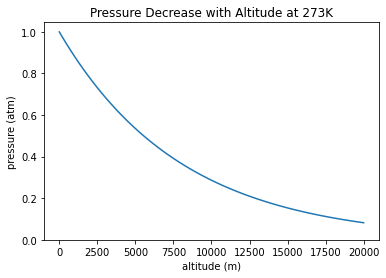

In [3]:
import matplotlib.pyplot as plt
from math import exp


def calculate_pressure(P_0, z, H):
    """
    Given the initial pressure P_0, height z, and scale height H,
    calculate the pressure at the given height.
    """
    try:
        # Get the pressure when z is a single value.
        return P_0 * exp(-z / H)
    except TypeError:
        # This is a NumPy array.
        return P_0 * np.exp(-z / H)


# Let's plot this out:
H = 8000  # Scale height when the temperature is 0 C in meters
P_0 = 1  # Pressure at sea level = 1 atm
z = np.linspace(0, 20_000, 100)
P = calculate_pressure(P_0, z, H)
plt.plot(z, P)
plt.title("Pressure Decrease with Altitude at 273K")
plt.xlabel("altitude (m)")
plt.ylabel("pressure (atm)")
plt.ylim(ymin=0)
plt.show()


If we think of the increase in pixel height at a given starting height as its "pressure", we can repurpose our function to calculate the new height after a pixel is changed.


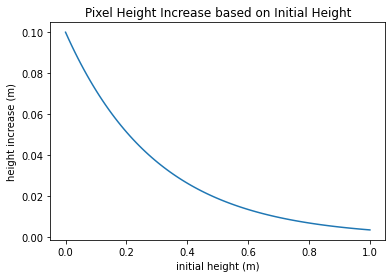

In [4]:
H = 0.3  # Scale height in meters
P_0 = 0.1  # Height increase for pixels with a starting height of 0 in meters.
z = np.linspace(0, 1, 100)
P = calculate_pressure(P_0, z, H)
plt.plot(z, P)
plt.title("Pixel Height Increase based on Initial Height")
plt.xlabel("initial height (m)")
plt.ylabel("height increase (m)")
plt.show()


## Iterate Through the Dataset

At this point, we have our dataset prepared and we have a way of converting heat values into pixel values. We can finally start iterating through the dataset to generate the color and heat maps.

For this, we will create a new function called `generate_maps()`. This function loads the data from the `.parquet` file and iterates through the dataset while saving the color and heat maps to the directories specified in its arguments.

To do this, `generate()` simulates the entire r/Place event, placing color and heat pixels on two "canvases" as it iterates through time:

- `img_color`: an 8-bit unsigned integer NumPy 3D array which holds the RGB values for each pixel in the color map. The initial color is white, just like the untouched canvas.
- `img_heat`: A 32-bit unsigned integer NumPy 2D array. Each value represents the heat of the most recent pixel to be placed there. The initial values are all set to zero, representing zero heat.

The iteration is interrupted with the timestamp of the current pixel exceeds the time of the current frame. The color and heat canvases are then saved as PNG and OpenEXR images, respectively. The iteration stops when either there are no more pixels in the dataset, or the desired amount of frames have been rendered.


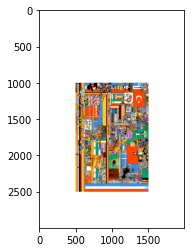

In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
import imageio
import matplotlib.pyplot as plt
from math import exp

TIMESTAMP_MAX = 300_589_892


def generate(
    infile,
    colorpath,
    datapath,
    start_ms=0,
    timescale=1000,
    frames=600,
    fps=60,
    heat_half_life=10 * 60 * 1000,
    scale_height=0.3,
):
    """Generate the heat and color frames for the given file."""

    df = pd.read_parquet(infile)

    # The time gap between frames.
    dt = round(timescale * 1000 / fps)

    # earlier we converted the hex colors from the r/Place dataset to a key.
    # We can use this tuple to convert the key to an RGB color.
    indexed_rgb = (
        (0, 0, 0),
        (0, 117, 111),
        (0, 158, 170),
        (0, 163, 104),
        (0, 204, 120),
        (0, 204, 192),
        (36, 80, 164),
        (54, 144, 234),
        (73, 58, 193),
        (81, 82, 82),
        (81, 233, 244),
        (106, 92, 255),
        (109, 0, 26),
        (109, 72, 47),
        (126, 237, 86),
        (129, 30, 159),
        (137, 141, 144),
        (148, 179, 255),
        (156, 105, 38),
        (180, 74, 192),
        (190, 0, 57),
        (212, 215, 217),
        (222, 16, 127),
        (228, 171, 255),
        (255, 56, 129),
        (255, 69, 0),
        (255, 153, 170),
        (255, 168, 0),
        (255, 180, 112),
        (255, 214, 53),
        (255, 248, 184),
        (255, 255, 255),
    )

    # Generate the canvases to hold the running values
    img_color = np.full((2999, 2000, 3), 255, dtype=np.uint8)
    img_heat = np.zeros((2999, 2000), dtype=np.float32)

    # Create an iterator that yields the rows of the dataset in order.
    px_iterator = df.itertuples()

    # Get the first pixel.
    px = next(px_iterator)

    # We won't bother calculating the heat for pixels that will be more than ten
    # half lives old by the time we reach the first frame. At ten half lives,
    # a pixel will be 1/1024th of it's initial height. We also make sure
    # the the buffer time is a multiple of the frame gap time (dt), so that the start
    # time is precise to the millisecond.
    heat_map_buffer_time = dt * (10 * heat_half_life // dt)
    calculation_start_time = max(0, start_ms - heat_map_buffer_time)

    # Iterate through the frames.
    frame_no = 0
    for ms in range(calculation_start_time, TIMESTAMP_MAX, dt):
        # Stop after the last frame.
        if frame_no >= frames:
            break

        # Draw pixels where timestamp <= ms
        while px.timestamp <= ms:
            # 0, 0 is the center of the canvas. We need to add 1500 to x and
            # 1000 to y so that 0, 0 is the top left corner.
            x_pos = px.x + 1500
            y_pos = px.y + 1000

            # Draw the pixel's color to the color canvas.
            img_color[x_pos, y_pos] = indexed_rgb[px.pixel_color]

            # Make the added height for new pixels
            #  decay exponentially with initial height.
            H_0 = 0.1
            img_heat[x_pos, y_pos] += calculate_pressure(
                H_0,  # Height increase for a pixel with starting height of 0
                img_heat[x_pos, y_pos],  # Initial height of this pixel
                scale_height,
            )

            try:
                # Get the next pixel.
                px = next(px_iterator)
            except StopIteration:
                # Break out of the loop if we've reached the end of the dataset.
                break

        # After all of the pixels less than the frame's timestamp have been drawn,
        # save the color and birthtime canvases as frames.
        img_heat = calculate_frame_heat(img_heat, heat_half_life, dt)

        if ms < start_ms:
            # Don't save the frame if it's before the start time.
            continue

        zero_arr = np.zeros((2999, 2000), dtype=np.float32)
        img_data = np.dstack((zero_arr, img_heat, zero_arr))

        # Save the frames.
        imageio.imwrite(
            colorpath / f"frame-{str(frame_no).zfill(4)}.png",
            img_color,
            optimize=True,
        )

        imageio.imwrite(
            datapath / f"frame-{str(frame_no).zfill(4)}.exr",
            img_data,
        )

        frame_no += 1


# Download the FreeImage backend library if it doesn't exist.
imageio.plugins.freeimage.download()

generate(
    Path("../gitignored/test_trimmed.parquet"),
    Path("../data/frames_color"),
    Path("../data/frames_heat"),
    start_ms=99645924 + 60 * 60 * 1000,  # one hour after first expansion
    # start_ms=195583041,  # second expansion
    # start_ms=295409870,  # last non-white pixel placed
    frames=1,  # Only save the first frame.
    timescale=(5 * 60 * 60 / 20),  # five hours => 20 seconds
    heat_half_life=(30 * 60 * 1000),  # 30 minute half life.
)

# Show the first color frame.
img_color = imageio.imread("../data/frames_color/frame-0000.png")
plt.imshow(img_color)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


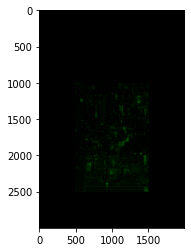

In [6]:
img_data = imageio.imread("../data/frames_heat/frame-0000.exr")

# matplotlib will complain about some of the pixels being clipped. This is fine.
# EXR format allows for values greater than one. I normally just try to get a result
# That's mostly black with a little bit of green mixed in.
plt.imshow(img_data)


## Next Steps

<!-- FIXME: This is a download link when it's viewed in Jupyter Notebook -->

[Continue with the "Rendering With Blender" section](3_blender.md)
